In [61]:
import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

In [62]:
import numpy as np
import os
import decimal

In [63]:
mainpath   = '/home/taylor/Documents/Research/spitzer/MEGA/'
planets = ['CoRoT-2b', 'HAT-P-7b', 'HAT-P-7b', 'HD149026b', 'HD149026b', 'KELT-16b', 'KELT-9b', 'MASCARA-1b', 'Qatar1b', 'Qatar1b', 'WASP-121b', 'WASP-121b', 'WASP-14b', 'WASP-14b', 'WASP-18b', 'WASP-18b', 'WASP-19b', 'WASP-19b', 'WASP-33b', 'WASP-33b', 'WASP-43b', 'WASP-43b', 'WASP-43b_repeatCh1', 'WASP-43b_repeatCh2', 'WASP-43b_repeat2Ch2', 'KELT-7b']
channels = ['ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch2', 'ch2', 'ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch1', 'ch2', 'ch2', 'ch2']

hide = ['WASP-121b', 'WASP-121b', 'WASP-43b_repeatCh1', 'WASP-43b_repeatCh2', 'WASP-43b_repeat2Ch2']
hide_channels = ['ch1', 'ch2', 'ch1', 'ch2', 'ch2']
for i in range(len(hide)):
    hide_ind = np.where(np.logical_and(np.array(planets)==hide[i], np.array(channels)==hide_channels[i]))[0][0]
    planets = np.delete(planets, hide_ind)
    channels = np.delete(channels, hide_ind)

planets = list(planets)
channels = list(channels)

twoLimits = False
onlyGoodFits = False
onlyBadFits = False

In [64]:
def recompute_Tb(fp_MCMC, rp_MCMC, A_MCMC, planet, channel, rootpath):
    if channel=='ch1':
        wav=3.6e-6
    else:
        wav=4.5e-6
    
    nIters = 10000
    fp_MCMC = np.random.normal(fp_MCMC[0], np.mean(fp_MCMC[1:]), nIters)
    rp_MCMC = np.random.normal(rp_MCMC[0], np.mean(rp_MCMC[1:]), nIters)
    A_MCMC = np.random.normal(A_MCMC[0], np.mean(A_MCMC[1:]), nIters)
    
    tstar_b = compute_Tstarb(planet, channel, rootpath)
    tstar_b = np.random.normal(tstar_b[0], tstar_b[1], nIters)
    
    tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC/rp_MCMC**2)))**-1
    tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC*(1-2*A_MCMC)/rp_MCMC**2)))**-1
    
    return np.array([np.nanmedian(tday), np.nanpercentile(tday, 84)-np.nanmedian(tday), np.nanmedian(tday)-np.nanpercentile(tday, 16),
            np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16)])

def compute_Tstarb(planet, channel, rootpath):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    # Get the phoenix file ready to compute the stellar brightness temperature
    teffStr = Tstar
    if teffStr <= 7000:
        teffStr = teffStr - (teffStr%100) + np.rint((teffStr%100)/100)*100
    elif teffStr > 7000:
        teffStr = teffStr - (teffStr%200) + np.rint((teffStr%200)/200)*200
    elif teffStr > 12000:
        teffStr = 12000
    teffStr = str(int(teffStr)).zfill(5)
    
    logg = data['st_logg'][nameIndex]
    if np.isnan(logg):
        logg = 4.5
    logg = logg - (logg%0.5) + np.rint((logg%0.5)*2)/2.
    logg = -logg
    feh = data['st_metfe'][nameIndex]
    if np.isnan(feh):
        feh = 0.
    feh = (feh - (feh%0.5) + np.rint((feh%0.5)*2)/2.)
    if feh<-2.:
        feh = (feh - (feh%1) + np.rint((feh%1)))
    
    webfolder = 'ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/'
    phoenixPath = rootpath+planet+'/phoenix/'
    phoenixWavFile = phoenixPath+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
    if not os.path.exists(phoenixPath):
        print('Downloading relevant PHOENIX wavelengths file...')
        os.mkdir(phoenixPath)
        try:
            _ = urllib.request.urlretrieve(webfolder+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', phoenixWavFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')

    webfolder += 'PHOENIX-ACES-AGSS-COND-2011/Z'+("{0:+.01f}".format(feh) if feh!=0 else '-0.0')+'/'

    webfile = ('lte'+teffStr
             +("{0:+.02f}".format(logg) if logg!=0 else '-0.00')
             +("{0:+.01f}".format(feh) if feh!=0 else '-0.0')
             +'.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

    phoenixSpectraFile = phoenixPath+webfile

    if not os.path.exists(phoenixSpectraFile):
        print('Downloading relevant PHOENIX spectra...')
        try:
            _ = urllib.request.urlretrieve(webfolder+webfile, phoenixSpectraFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')
    
    f = fits.open(phoenixSpectraFile)
    fStar = f[0].data*1e-1 # 'erg/s/cm^2/cm' to kg/s^3
    f.close()
    f = fits.open(phoenixWavFile)
    wavStar = f[0].data*1e-4 # angstrom to micron
    f.close()

    def planck(wav, T):
        intensity = (2.0*const.h.value*const.c.value**2) / ((wav**5) * (np.exp(const.h.value*const.c.value/(wav*const.k_B.value*T)) - 1.0))
        return intensity
    def fluxDiff(temp, fStarSummed, wavs):
        #factor of pi likely needed to account for emitting area (pi*rstar^2 where rstar=1)
        return (np.sum(planck(wavs, temp)*np.pi)-fStarSummed)**2
    temps = np.linspace(5500, 7000, 500)
    if channel == 'ch1':
        incides = np.where(np.logical_and(wavStar < 4., wavStar > 3.))[0]
    else:
        incides = np.where(np.logical_and(wavStar < 5., wavStar > 4.))[0]
    diffs = [fluxDiff(temp, np.sum(fStar[incides]), wavStar[incides]*1e-6) for temp in temps]
    tstar_b = temps[np.argmin(diffs)]
    
    return tstar_b, Tstar_err
    
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
#     Rstar = data['st_rad'][nameIndex]
#     Rstar_err = np.mean([data['st_raderr1'][nameIndex],
#                                 -data['st_raderr2'][nameIndex]])
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
#     Rstar = np.random.normal(Rstar, Rstar_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [113]:
planet='KELT-16b'
channel='ch2'
with open(mainpath+planet+'/analysis/'+channel+'/bestPhOption.txt') as f:
    line = f.readline().strip()
    foldername = mainpath+line[line.find(planet):]+'/'
np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

array(['/home/taylor/Documents/Research/spitzer/MEGA/KELT-16b/analysis/ch2/addedBlank/noIgnore/4umPLD_3x3/',
       '/home/taylor/Documents/Research/spitzer/MEGA/KELT-16b/analysis/ch2/addedBlank/noIgnore/4umPLD_5x5/'],
      dtype='<U98')

In [117]:
def roundToSigFigs(x, sigFigs=2):
    nDec = -int(np.floor(np.log10(np.abs(x))))+sigFigs-1
    rounded = np.round(x, nDec)
    if nDec <= 0:
        #remove decimals if this should be an integer
        rounded = int(rounded)
    output = str(rounded)
    if nDec > 1 and np.rint(rounded*10**nDec) % 10 == 0:
        #take care of the trailing zero issue
        output += '0'
    return nDec, output

def roundToDec(x, nDec=2):
    rounded = np.round(x, nDec)
    if nDec <= 0:
        #remove decimals if this should be an integer
        rounded = int(rounded)
    output = str(rounded)
    if nDec > 1 and np.rint(rounded*10**nDec) % 10 == 0:
        #take care of the trailing zero issue
        output += '0'
    return output

def makeTable1(planets, channels, twoLimits):
    output = r'''\begin{deluxetable*}{cc|cccc}[!htbp]
    \tabletypesize{\footnotesize}
    \tablewidth{\textwidth}
    \tablehead{\colhead{Data Set} & \colhead{Model} & \colhead{$\chi^2/n_{\rm data}$} & \colhead{$\sigma_F$ (ppm)} & \colhead{$\sigma_F/\sigma_{\rm limit}$} & \colhead{$F_{\rm day}/F_*$ (ppm)}}
    \decimals
    \startdata'''+'\n'
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        with open(mainpath+planet+'/analysis/'+channel+'/bestPhOption.txt') as f:
            line = f.readline().strip()
            foldername = mainpath+line[line.find(planet):]+'/'
        
        pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

        modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
        for i in range(len(pldFoldernames)):
            modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
        
        #find the best modes
        BICs = []
        nDatas = []
        for mode in modes:
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            
            if not os.path.exists(savepath):
                BICs.append(np.inf)
                nDatas.append(1)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
                nDatas.append(ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0])
        BICs = np.array(BICs)
        nDatas = np.array(nDatas)
        
        try:
            bestBIC = BICs[np.argmin(BICs/nDatas)]
        except:
            # There are no analyses for this planet
            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '
            output += '? & ? & ? & ? & ? '
            output += ' \\\\ % \n'
            continue

        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            ResultMCMC = np.load(savepath)

            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '

            if 'poly' in mode.lower():
                ind = mode.lower().find('poly')
                output += mode[ind:ind+5]
            elif 'bliss' in mode.lower():
                output += 'BLISS'
            elif 'pld' in mode.lower():
                output += 'PLD'
            elif 'gp' in mode.lower():
                output += 'GP'

            if 'tslope' in mode.lower():
                output += '*$f$(t)'

            if 'hside' in mode.lower():
                output += '*Step'

            if 'psfw' in mode.lower():
                output += ', PSFW'
            
            if 'trim' in mode.lower():
                output += ', Trim'

            output += ', '

            ind = mode.lower().find('_v')
            vorder = mode[ind+1:].split('_')[0][1:]

            if vorder == '1':
                output += '1st Order'
            elif vorder == '2':
                output += '2nd Order'

            if 'ellipse' in mode.lower() and 'offset' in mode.lower():
                output += ' + Rotated Ellipse & '
            elif 'ellipse' in mode.lower():
                output += ' + Ellipse & '
            else:
                output += ' & '


            output += '$'+str(roundToSigFigs(ResultMCMC['chi2datum'][0], sigFigs=4)[1])+'$ & '
            output += '$'+str(roundToDec(ResultMCMC['sigF'][0]*1e6, 0))+'$ & '
            try:
                output += '$'+str(roundToSigFigs(ResultMCMC['sigF'][0]*1e6/ResultMCMC['sigF_photon_ppm'][0], sigFigs=4)[1])+'$ & '
            except:
                if planet=='MASCARA-1b':
                    sigF_photon_ppm = 535/2.232
                    output += '$'+str(roundToSigFigs(ResultMCMC['sigF'][0]*1e6/sigF_photon_ppm, sigFigs=4)[1])+'$ & '
                elif planet=='KELT-16b':
                    sigF_photon_ppm = 1644/1.801
                    output += '$'+str(roundToSigFigs(ResultMCMC['sigF'][0]*1e6/sigF_photon_ppm, sigFigs=4)[1])+'$ & '
                else:
                    output += '? & '

            val = ResultMCMC['fp']*1e6
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$'

            output += ' \\\\ % \n'

    output += r'''    \enddata
\end{deluxetable*}'''

    return output
    
def makeTable2(planets, channels, twoLimits):
    output = r'''\begin{deluxetable*}{cc|cccccc}[!htbp]
    \tabletypesize{\footnotesize}
    \tablewidth{\textwidth}
    \tablehead{\colhead{Data Set} & \colhead{Model} & \colhead{$R_{\rm p}/R_{\rm *}$} & \colhead{$a/R_{\rm *}$} & \colhead{$i$ ($^{\circ}$)} & \colhead{$e$} & \colhead{$\omega$ ($^{\circ}$)}}
    \decimals
    \startdata'''+'\n'
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        with open(mainpath+planet+'/analysis/'+channel+'/bestPhOption.txt') as f:
            line = f.readline().strip()
            foldername = mainpath+line[line.find(planet):]+'/'

        modes = np.sort([x[0].split('/')[-1] for x in os.walk(mainpath+line[line.find(planet):])][1:])

        #find the best modes
        BICs = []
        nDatas = []
        for mode in modes:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            if not os.path.exists(savepath):
                BICs.append(np.inf)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
                nDatas.append(ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0])
        BICs = np.array(BICs)
        nDatas = np.array(nDatas)

        try:
            bestBIC = BICs[np.argmin(BICs/nDatas)]
        except:
            # There are no analyses for this planet
            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '
            output += '? & ? & ? & ? & ? & ? '
            output += ' \\\\ % \n'
            continue

        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]
            savepath   = foldername + mode + '/' + 'ResultMCMC_'+mode+'_Params.npy'
            ResultMCMC = np.load(savepath)

            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '

            if 'poly' in mode.lower():
                ind = mode.lower().find('poly')
                output += mode[ind:ind+5]
            elif 'bliss' in mode.lower():
                output += 'BLISS'
            elif 'pld' in mode.lower():
                output += 'PLD'
            elif 'gp' in mode.lower():
                output += 'GP'

            if 'tslope' in mode.lower():
                output += '*$f$(t)'

            if 'hside' in mode.lower():
                output += '*Step'

            if 'psfw' in mode.lower():
                output += ', PSFW'
            
            if 'trim' in mode.lower():
                output += ', Trim'

            output += ', '

            ind = mode.lower().find('_v')
            vorder = mode[ind+1:].split('_')[0][1:]

            if vorder == '1':
                output += '1st Order'
            elif vorder == '2':
                output += '2nd Order'

            if 'ellipse' in mode.lower() and 'offset' in mode.lower():
                output += ' + Rotated Ellipse & '
            elif 'ellipse' in mode.lower():
                output += ' + Ellipse & '
            else:
                output += ' & '


            #rp/rs, a/rs, per, inc, ecc, fday/fstar
            val = ResultMCMC['rp']
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '

            val = ResultMCMC['a']
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '

            val = ResultMCMC['inc']
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '
            
            try:
                ecosw = ResultMCMC['ecosw']
                esinw = ResultMCMC['ecosw']
            except:
                output += '-- & '
                output += '-- & '
                output += ' \\\\ % \n'
                continue

            ecosw = np.random.normal(ecosw[0], np.mean(ecosw[1:3]), 100000)
            esinw = np.random.normal(esinw[0], np.mean(esinw[1:3]), 100000)

            ecc = np.sqrt(ecosw**2 + esinw**2)
            #longitude of periastron needs to be in degrees for batman!
            w   = np.arctan2(esinw, ecosw)*180./np.pi

            val = [np.median(ecc), np.std(ecc), np.std(ecc)]
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '

            if np.median(ecc)/np.std(ecc) < 3:
                output += '-- & '
            else:
                val = [np.median(w), np.std(w), np.std(w)]
                if twoLimits:
                    nDec1, err1 = roundToSigFigs(val[1])
                    nDec2, err2 = roundToSigFigs(val[2])
                    nDec = np.max([nDec1, nDec2])
                    val = roundToDec(val[0], nDec)
                    output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
                else:
                    nDec, err = roundToSigFigs(np.mean(val[1:]))
                    val = roundToDec(val[0], nDec)
                    output += '$'+val+'\pm'+err+'$ & '

            output += ' \\\\ % \n'

    output += r'''    \enddata
\end{deluxetable*}'''

    return output

def makeTable3(planets, channels, twoLimits):
    output = r'''\begin{deluxetable*}{cc|ccccccc}[!htbp]
    \tabletypesize{\footnotesize}
    \tablewidth{\textwidth}
    \tablehead{\colhead{Data Set} & \colhead{Model} & \colhead{1st Amp.} & \colhead{1st Offset} & \colhead{2nd Amp.} & \colhead{2nd offset} & \colhead{$T_{\rm day}$ (K)} & \colhead{$T_{\rm night}$ (K)}}
    \decimals
    \startdata'''+'\n'
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        with open(mainpath+planet+'/analysis/'+channel+'/bestPhOption.txt') as f:
            line = f.readline().strip()
            foldername = mainpath+line[line.find(planet):]+'/'

        modes = np.sort([x[0].split('/')[-1] for x in os.walk(mainpath+line[line.find(planet):])][1:])

        #find the best modes
        BICs = []
        nDatas = []
        for mode in modes:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            if not os.path.exists(savepath):
                BICs.append(np.inf)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
                nDatas.append(ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0])
        BICs = np.array(BICs)
        nDatas = np.array(nDatas)

        try:
            bestBIC = BICs[np.argmin(BICs/nDatas)]
        except:
            # There are no analyses for this planet
            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '
            output += '? & ? & ? & ? & ? & ? & ? '
            output += ' \\\\ % \n'
            continue


        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]
            savepath   = foldername + mode + '/' + 'ResultMCMC_'+mode+'_Params.npy'
            ResultMCMC = np.load(savepath)

            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '

            if 'poly' in mode.lower():
                ind = mode.lower().find('poly')
                output += mode[ind:ind+5]
            elif 'bliss' in mode.lower():
                output += 'BLISS'
            elif 'pld' in mode.lower():
                output += 'PLD'
            elif 'gp' in mode.lower():
                output += 'GP'

            if 'tslope' in mode.lower():
                output += '*$f$(t)'

            if 'hside' in mode.lower():
                output += '*Step'

            if 'psfw' in mode.lower():
                output += ', PSFW'
            
            if 'trim' in mode.lower():
                output += ', Trim'

            output += ', '

            ind = mode.lower().find('_v')
            vorder = mode[ind+1:].split('_')[0][1:]

            if vorder == '1':
                output += '1st Order'
            elif vorder == '2':
                output += '2nd Order'

            if 'ellipse' in mode.lower() and 'offset' in mode.lower():
                output += ' + Rotated Ellipse & '
            elif 'ellipse' in mode.lower():
                output += ' + Ellipse & '
            else:
                output += ' & '

            A = ResultMCMC['A']
            B = ResultMCMC['B']

            A = np.random.normal(A[0], np.mean(A[1:3]), 10000)
            B = np.random.normal(B[0], np.mean(B[1:3]), 10000)

            amplitude = 2*np.sqrt(A**2+B**2)
            offset = np.arctan2(B, A)*180/np.pi

            val = [np.median(amplitude), np.std(amplitude), np.std(amplitude)]
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '

            if np.median(offset) < 0:
                direction = 'E'
            else:
                direction = 'W'
            val = [np.abs(np.median(offset)), np.std(offset), np.std(offset)]
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}~^{\circ}$'+direction+' & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'~^{\circ}$'+direction+' & '


            if vorder == '1':
                output += '-- & -- & '
            else:
                C = ResultMCMC['C']
                D = ResultMCMC['D']

                C = np.random.normal(C[0], np.mean(C[1:3]), 10000)
                D = np.random.normal(D[0], np.mean(D[1:3]), 10000)

                amplitude = 2*np.sqrt(C**2+D**2)
                offset = np.arctan2(D, C)*180/np.pi/2

                val = [np.median(amplitude), np.std(amplitude), np.std(amplitude)]
                if twoLimits:
                    nDec1, err1 = roundToSigFigs(val[1])
                    nDec2, err2 = roundToSigFigs(val[2])
                    nDec = np.max([nDec1, nDec2])
                    val = roundToDec(val[0], nDec)
                    output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
                else:
                    nDec, err = roundToSigFigs(np.mean(val[1:]))
                    val = roundToDec(val[0], nDec)
                    output += '$'+val+'\pm'+err+'$ & '

                if np.median(offset) < 0:
                    direction = 'E'
                else:
                    direction = 'W'
                val = [np.abs(np.median(offset)), np.std(offset), np.std(offset)]
                if twoLimits:
                    nDec1, err1 = roundToSigFigs(val[1])
                    nDec2, err2 = roundToSigFigs(val[2])
                    nDec = np.max([nDec1, nDec2])
                    val = roundToDec(val[0], nDec)
                    output += '$'+val+'^{+'+err1+'}_{-'+err2+'}~^{\circ}$'+direction+' & '
                else:
                    nDec, err = roundToSigFigs(np.mean(val[1:]))
                    val = roundToDec(val[0], nDec)
                    output += '$'+val+'\pm'+err+'~^{\circ}$'+direction+' & '

            newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                                 planet, channel, mainpath)
            Tday = newTb[[0,1,2]]
            Tnight = newTb[[3,4,5]]
                    
            val = Tday
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '

            val = Tnight
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '



            output += ' \\\\ % \n'

    output += r'''    \enddata
\end{deluxetable*}'''

    return output

def makePosterTable(planets, channels, twoLimits):
    output = r'''\begin{deluxetable*}{cc|ccccccc}[!htbp]
    \tabletypesize{\footnotesize}
    \tablewidth{\textwidth}
    \tablehead{\colhead{Data Set} & \colhead{Model} & \colhead{$F_{\rm day}/F_{\rm *}$} & \colhead{Amplitude} & \colhead{Offset} & \colhead{$T_{\rm day}$ (K)} & \colhead{$T_{\rm night}$ (K)}}
    \decimals
    \startdata'''+'\n'
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        with open(mainpath+planet+'/analysis/'+channel+'/bestPhOption.txt') as f:
            line = f.readline().strip()
            foldername = mainpath+line[line.find(planet):]+'/'

        modes = np.sort([x[0].split('/')[-1] for x in os.walk(mainpath+line[line.find(planet):])][1:])
        
        #find the best modes
        BICs = []
        nDatas = []
        for mode in modes:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            if not os.path.exists(savepath):
                BICs.append(np.inf)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
                nDatas.append(ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0])
        BICs = np.array(BICs)
        nDatas = np.array(nDatas)

        try:
            bestBIC = BICs[np.argmin(BICs/nDatas)]
        except:
            # There are no analyses for this planet
            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '
            output += '? & ? & ? & ? & ? & ? & ? '
            output += ' \\\\ % \n'
            continue


        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]
            savepath   = foldername + mode + '/' + 'ResultMCMC_'+mode+'_Params.npy'
            ResultMCMC = np.load(savepath)

            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            output += '        '+planetName+', '+channel+' & '

            if 'poly' in mode.lower():
                ind = mode.lower().find('poly')
                output += mode[ind:ind+5]
            elif 'bliss' in mode.lower():
                output += 'BLISS'
            elif 'pld' in mode.lower():
                output += 'PLD'
            elif 'gp' in mode.lower():
                output += 'GP'

            if 'tslope' in mode.lower():
                output += '*$f$(t)'

            if 'hside' in mode.lower():
                output += '*Step'

            if 'psfw' in mode.lower():
                output += ', PSFW'

            output += ', '

            ind = mode.lower().find('_v')
            vorder = mode[ind+1:].split('_')[0][1:]

            if vorder == '1':
                output += '1st Order'
            elif vorder == '2':
                output += '2nd Order'

            if 'ellipse' in mode.lower() and 'offset' in mode.lower():
                output += ' + Rotated Ellipse & '
            elif 'ellipse' in mode.lower():
                output += ' + Ellipse & '
            else:
                output += ' & '

            val = ResultMCMC['fp']
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1]*1e6)
                nDec2, err2 = roundToSigFigs(val[2]*1e6)
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0]*1e6, nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:])*1e6)
                val = roundToDec(val[0]*1e6, nDec)
                output += '$'+val+'\pm'+err+'$ & '
            
            A = ResultMCMC['A']
            B = ResultMCMC['B']

            A = np.random.normal(A[0], np.mean(A[1:3]), 10000)
            B = np.random.normal(B[0], np.mean(B[1:3]), 10000)

            amplitude = 2*np.sqrt(A**2+B**2)
            offset = np.arctan2(B, A)*180/np.pi

            val = [np.median(amplitude), np.std(amplitude), np.std(amplitude)]
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '

            if np.median(offset) < 0:
                direction = 'E'
            else:
                direction = 'W'
            val = [np.abs(np.median(offset)), np.std(offset), np.std(offset)]
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}~^{\circ}$'+direction+' & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'~^{\circ}$'+direction+' & '

            newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                                 planet, channel, mainpath)
            Tday = newTb[[0,1,2]]
            Tnight = newTb[[3,4,5]]
                    
            val = Tday
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '

            val = Tnight
            if twoLimits:
                nDec1, err1 = roundToSigFigs(val[1])
                nDec2, err2 = roundToSigFigs(val[2])
                nDec = np.max([nDec1, nDec2])
                val = roundToDec(val[0], nDec)
                output += '$'+val+'^{+'+err1+'}_{-'+err2+'}$ & '
            else:
                nDec, err = roundToSigFigs(np.mean(val[1:]))
                val = roundToDec(val[0], nDec)
                output += '$'+val+'\pm'+err+'$ & '



            output += ' \\\\ % \n'

    output += r'''    \enddata
\end{deluxetable*}'''

    return output

def trimPlanets(planets, channels, onlyGoodFits, onlyBadFits):
    new_planets = []
    new_channels = []
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        with open(mainpath+planet+'/analysis/'+channel+'/bestPhOption.txt') as f:
            line = f.readline().strip()
            foldername = mainpath+line[line.find(planet):]+'/'

        modes = np.sort([x[0].split('/')[-1] for x in os.walk(mainpath+line[line.find(planet):])][1:])

        #find the best modes
        BICs = []
        for mode in modes:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            if not os.path.exists(savepath):
                BICs.append(np.inf)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
        BICs = np.array(BICs)

        try:
            bestBIC = np.min(BICs)
        except:
            continue

        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]

            savepath   = foldername + mode + '/' + 'ResultMCMC_'+mode+'_Params.npy'
            if not os.path.exists(savepath):
                continue

            ResultMCMC = np.load(savepath)

            try:
                ratio = ResultMCMC['sigF'][0]*1e6/ResultMCMC['sigF_photon_ppm'][0]
            except:
                if planet=='MASCARA-1b':
                    sigF_photon_ppm = 535/2.232
                    ratio = ResultMCMC['sigF'][0]*1e6/sigF_photon_ppm
                elif planet=='KELT-16b':
                    sigF_photon_ppm = 1644/1.801
                    ratio = ResultMCMC['sigF'][0]*1e6/sigF_photon_ppm
                else:
                    continue
            
            if onlyGoodFits and ratio <= 2:
                new_planets.append(planets[iterNum])
                new_channels.append(channels[iterNum])
            elif onlyBadFits and ratio > 2:
                print(planet, channel, 'is bad')
                new_planets.append(planets[iterNum])
                new_channels.append(channels[iterNum])
    return new_planets, new_channels

def addFileHeader():
    return r'''\documentclass[onecolumn]{aastex62}
\usepackage[utf8]{inputenc}
% \usepackage[margin=1in]{geometry}
\usepackage[section]{placeins}
\renewcommand{\floatpagefraction}{.99}%

\begin{document}
\pagenumbering{gobble}
'''
    

In [118]:
if onlyGoodFits or onlyBadFits:
    planets_temp, channels_temp = trimPlanets(planets, channels, onlyGoodFits, onlyBadFits)
else:
    planets_temp, channels_temp = planets, channels

In [119]:
output = addFileHeader()
output += makeTable1(planets_temp, channels_temp, twoLimits)
print(output)

\documentclass[onecolumn]{aastex62}
\usepackage[utf8]{inputenc}
% \usepackage[margin=1in]{geometry}
\usepackage[section]{placeins}
\renewcommand{\floatpagefraction}{.99}%

\begin{document}
\pagenumbering{gobble}
\begin{deluxetable*}{cc|cccc}[!htbp]
    \tabletypesize{\footnotesize}
    \tablewidth{\textwidth}
    \tablehead{\colhead{Data Set} & \colhead{Model} & \colhead{$\chi^2/n_{\rm data}$} & \colhead{$\sigma_F$ (ppm)} & \colhead{$\sigma_F/\sigma_{\rm limit}$} & \colhead{$F_{\rm day}/F_*$ (ppm)}}
    \decimals
    \startdata
        CoRoT-2b, ch2 & Poly3, 2nd Order & $0.9893$ & $1442$ & $1.987$ & $4200\pm150$ \\ % 
        HAT-P-7b, ch1 & Poly4, 2nd Order & $0.9792$ & $1300$ & $3.642$ & $1830\pm140$ \\ % 
        HAT-P-7b, ch2 & Poly3, 2nd Order & $0.9891$ & $885$ & $1.801$ & $2117\pm80$ \\ % 
        HD149026b, ch1 & Poly4, 2nd Order & $1.009$ & $1242$ & $4.916$ & $3230\pm180$ \\ % 
        HD149026b, ch2 & Poly5, 2nd Order & $1.008$ & $666$ & $1.803$ & $356\pm32$ \\ % 
        KEL

In [21]:
output = addFileHeader()
output += makeTable1(planets_temp, channels_temp, twoLimits)
output += '\n\n\n\n'
output += makeTable2(planets_temp, channels_temp, twoLimits)
output += '\n\n\n\n'
output += makeTable3(planets_temp, channels_temp, twoLimits)
output += '\n\n\n\n'
output += '\end{document}'
print(output)

\documentclass[onecolumn]{aastex62}
\usepackage[utf8]{inputenc}
% \usepackage[margin=1in]{geometry}
\usepackage[section]{placeins}
\renewcommand{\floatpagefraction}{.99}%

\begin{document}
\pagenumbering{gobble}
\begin{deluxetable*}{cc|cccc}[!htbp]
    \tabletypesize{\footnotesize}
    \tablewidth{\textwidth}
    \tablehead{\colhead{Data Set} & \colhead{Model} & \colhead{$\chi^2/n_{\rm data}$} & \colhead{$\sigma_F$ (ppm)} & \colhead{$\sigma_F/\sigma_{\rm limit}$} & \colhead{$F_{\rm day}/F_*$ (ppm)}}
    \decimals
    \startdata
        CoRoT-2b, ch2 & Poly3, 2nd Order & $0.9893$ & $1442$ & $1.987$ & $4200\pm150$ \\ % 
        HAT-P-7b, ch1 & Poly4, 2nd Order & $0.9792$ & $1300$ & $3.642$ & $1830\pm140$ \\ % 
        HAT-P-7b, ch2 & Poly3, 2nd Order & $0.9891$ & $885$ & $1.801$ & $2117\pm80$ \\ % 
        HD149026b, ch1 & Poly4, 2nd Order & $1.009$ & $1242$ & $4.916$ & $3230\pm180$ \\ % 
        HD149026b, ch2 & Poly5, 2nd Order & $1.008$ & $666$ & $1.803$ & $356\pm32$ \\ % 
        KEL

\end{document}


In [30]:
planets_temp, channels_temp = trimPlanets(planets, channels, onlyGoodFits=True, onlyBadFits=False)
remove = np.where(np.isin(planets_temp, 'Qatar1b'))[0][0]
planets_temp = np.delete(planets_temp, remove)
channels_temp = np.delete(channels_temp, remove)

remove = np.where(np.isin(planets_temp, 'HD149026b'))[0][0]
planets_temp = np.delete(planets_temp, remove)
channels_temp = np.delete(channels_temp, remove)

remove = np.where(np.isin(planets_temp, 'HAT-P-7b'))[0][0]
planets_temp = np.delete(planets_temp, remove)
channels_temp = np.delete(channels_temp, remove)


planets_temp = np.append(planets_temp, 'WASP-33b')
channels_temp = np.append(channels_temp, 'ch2')
planets_temp = np.append(planets_temp, 'MASCARA-1b')
channels_temp = np.append(channels_temp, 'ch2')
output = addFileHeader()
output += makePosterTable(planets_temp, channels_temp, twoLimits)
output += '\n\n\n\n'
output += '\end{document}'
print(output)

\documentclass[onecolumn]{aastex62}
\usepackage[utf8]{inputenc}
% \usepackage[margin=1in]{geometry}
\usepackage[section]{placeins}
\renewcommand{\floatpagefraction}{.99}%

\begin{document}
\pagenumbering{gobble}
\begin{deluxetable*}{cc|ccccccc}[!htbp]
    \tabletypesize{\footnotesize}
    \tablewidth{\textwidth}
    \tablehead{\colhead{Data Set} & \colhead{Model} & \colhead{$F_{\rm day}/F_{\rm *}$} & \colhead{Amplitude} & \colhead{Offset} & \colhead{$T_{\rm day}$ (K)} & \colhead{$T_{\rm night}$ (K)}}
    \decimals
    \startdata
        CoRoT-2b, ch2 & Poly3, 2nd Order & $4200\pm150$ & $0.893\pm0.051$ & $22.2\pm4.7~^{\circ}$W & $1813\pm42$ & $954\pm71$ &  \\ % 
        KELT-16b, ch2 & GP, 1st Order & $4880\pm220$ & $0.82\pm0.12$ & $3\pm10~^{\circ}$W & $3150\pm110$ & $1390\pm310$ &  \\ % 
        KELT-9b, ch2 & Poly3, 1st Order & $3101\pm39$ & $0.605\pm0.028$ & $18.3\pm2.7~^{\circ}$E & $4000\pm220$ & $2360\pm140$ &  \\ % 
        WASP-18b, ch2 & Poly3, 1st Order & $4043\pm96$ & $0.887\p

In [31]:
for i in range(len(planets)):
    print(planets[i]+','+channels[i])

CoRoT-2b,ch2
HAT-P-7b,ch1
HAT-P-7b,ch2
HD149026b,ch1
HD149026b,ch2
KELT-16b,ch2
KELT-9b,ch2
MASCARA-1b,ch2
Qatar1b,ch1
Qatar1b,ch2
WASP-14b,ch1
WASP-14b,ch2
WASP-18b,ch1
WASP-18b,ch2
WASP-19b,ch1
WASP-19b,ch2
WASP-33b,ch1
WASP-33b,ch2
WASP-43b,ch1
WASP-43b,ch2
KELT-7b,ch2


In [32]:
# planets_temp, channels_temp = trimPlanets(planets, channels, onlyGoodFits=True, onlyBadFits=False)
# remove = np.where(np.isin(planets_temp, 'Qatar1b'))[0][0]
# planets_temp = np.delete(planets_temp, remove)
# channels_temp = np.delete(channels_temp, remove)
# planets_temp = np.append(planets_temp, 'WASP-33b')
# channels_temp = np.append(channels_temp, 'ch2')

In [33]:
Tb = '$1812\pm42$ & $953\pm72$, $3130\pm110$ & $1000\pm210$, $4000\pm230$ & $2360\pm130$, $3126\pm55$ & $1139\pm87$, $2451\pm71$ & $1390\pm130$, $1725\pm49$ & $770\pm110$, $3167\pm41$ & $1573\pm39$, $3006\pm81$ & $1060\pm220$'.split(',')
Tb = np.array([np.array(Tb[i].split(' & ')) for i in range(len(Tb))])
Td = np.array([np.array(Tb[i,0].replace('$', '').split('\\pm')).astype(float) for i in range(len(Tb))])
Tn = np.array([np.array(Tb[i,1].replace('$', '').split('\\pm')).astype(float) for i in range(len(Tb))])

T0 = np.array([compute_T0(planet) for planet in planets_temp])

In [35]:
offset = '$22.2\pm4.6~^{\circ}$W, $7.8\pm6.4~^{\circ}$W, $18.3\pm2.7~^{\circ}$E,$3.2\pm1.6~^{\circ}$W, $1.7\pm4.7~^{\circ}$W, $10.4\pm2.8~^{\circ}$E, $24.03\pm0.88~^{\circ}$E, $10.1\pm7.7~^{\circ}$W'.replace('$', '').replace('~^{\\circ}', '').replace(' ','').split(',')
orientation = np.array([offset[i][-1] for i in range(len(offset))])
offset_temp = np.array([np.array(offset[i][:-1].split('\\pm')).astype(float) for i in range(len(offset))])
offset = np.array([np.array([offset_temp[i,0]*(1-2*int(orientation[i]=='W')), offset_temp[i,1]]) for i in range(len(offset_temp))])

In [36]:
order = np.argsort(T0[:,0])
T0=T0[order]
Td=Td[order]
Tn=Tn[order]
offset=offset[order]
planets_temp=planets_temp[order]

In [58]:
import matplotlib
import matplotlib.pyplot as plt
preamble = [
    r'\usepackage{fontspec}',
    r'\setmainfont{Linux Libertine O}',
]
fontsize = 20
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
matplotlib.rcParams.update(params)

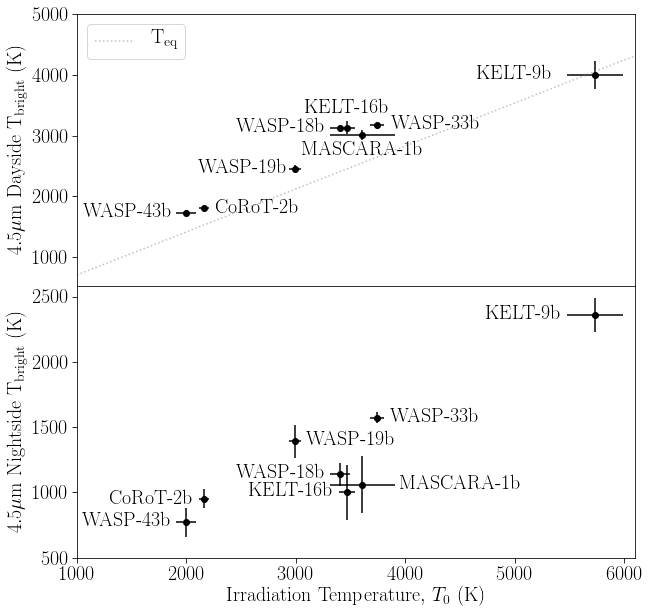

In [59]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10,10))

ax[0].errorbar(T0[:,0], Td[:,0], xerr=T0[:,1], yerr=Td[:,1], fmt='o', color='k')
ax[0].plot([1000,6100], np.array([1000,6100])*0.25**0.25, c='grey', ls='dotted', alpha=0.5, label=r'$\rm T_{eq}$')
left=[0,2,3,7]
top=[4]
bottom=[5]
for i in range(len(planets_temp)):
    if i in left:
        ax[0].text(T0[i,0]-T0[i,1]*1.5, Td[i,0]+0, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='right', va='center')
    elif i in top:
        ax[0].text(T0[i,0], Td[i,0]+Td[i,1]*1.5, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='center', va='bottom')
    elif i in bottom:
        ax[0].text(T0[i,0], Td[i,0]-Td[i,1]*1.5, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='center', va='top')
    else:
        ax[0].text(T0[i,0]+T0[i,1]*2, Td[i,0]+0, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='left', va='center')
ax[0].set_xlim(1000,6100)
ax[0].set_ylim(top=5000)
ax[0].set_ylabel(r'$\rm 4.5\mu m~Dayside~T_{bright}~(K)$')
ax[0].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')
ax[0].legend(loc=2)

ax[1].errorbar(T0[:,0], Tn[:,0], xerr=T0[:,1], yerr=Tn[:,1], fmt='o', color='k')
right=[0,1,3,4,7]
for i in range(len(planets_temp)):
    if i in right:
        ax[1].text(T0[i,0]-T0[i,1]-50, Tn[i,0]+0, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='right', va='center')
    else:
        ax[1].text(T0[i,0]+T0[i,1]+50, Tn[i,0]+0, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='left', va='center')
ax[1].set_ylim(500)
ax[1].set_ylabel(r'$\rm 4.5\mu m~Nightside~T_{bright}~(K)$')
ax[1].set_xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')

plt.savefig('/home/taylor/Downloads/Tb_T0.png', dpi=400, bbox_inches='tight')

plt.show()

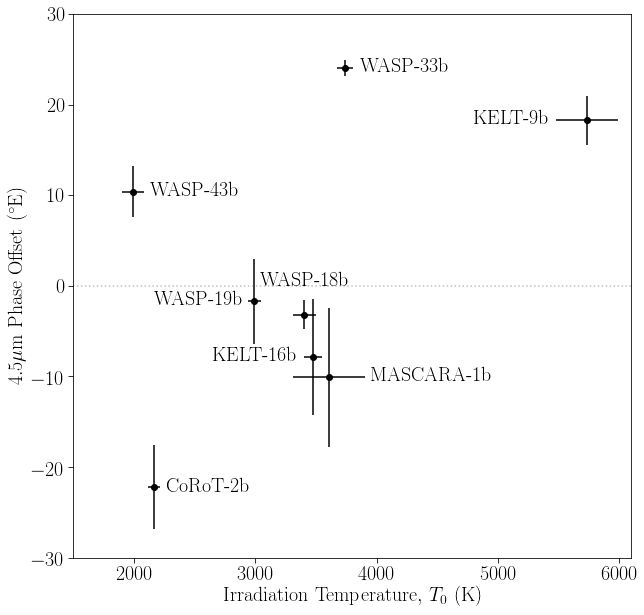

In [60]:
plt.figure(figsize=(10,10))
plt.errorbar(T0[:,0], offset[:,0], xerr=T0[:,1], yerr=offset[:,1], fmt='o', color='k')
right=[2,4,7]
top=[3]
for i in range(len(planets_temp)):
    if i in right:
        plt.text(T0[i,0]-T0[i,1]-50, offset[i,0]+0, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='right', va='center')
    elif i in top:
        plt.text(T0[i,0], offset[i,0]+offset[i,1]+1, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='center', va='bottom')
    else:
        plt.text(T0[i,0]+T0[i,1]+50, offset[i,0]+0, r'$\rm '+planets_temp[i].replace('-',r'$-$\rm ')+'$', ha='left', va='center')

plt.plot([1500,6100],[0,0],c='grey',ls='dotted',alpha=0.5)

plt.xlim(1500,6100)
plt.ylim(-30,30)
plt.ylabel(r'$\rm 4.5\mu m~Phase~Offset~(^{\circ}E)$')
plt.xlabel(r'${\rm Irradiation~Temperature,}~T_{\rm 0} ~({\rm K})$')

plt.savefig('/home/taylor/Downloads/offset_T0.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# WASP-33, 